In [ ]:
!pip3 install gym
!pip3 install opencv-python
!pip3 install 'gym[atari]'

In [ ]:
# Factor A
# Risk/Reward --> Low High
# --------------> 0.5 2.0
# 
# 
# Factor B
# Sample Size/Buffer Size --> Low High
# --------------------------> 0.2 0.8
# 
# 
# Factor C
# Epsilon --> Low    High
# ----------> Linear Exponential

In [1]:
''' CHANGE ENVIRONMENT HERE'''
''' ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ '''
env_id = "PongNoFrameskip-v0"
''' ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ '''
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
from torch.autograd import Variable
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# out_dir = '/u/training/tra442/scratch/'
out_dir = 'outdir/'

In [4]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

from wrappers import make_atari, wrap_deepmind, wrap_pytorch
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


    
def Training(risk="Low",sample_ratio="Low",epsilon_decay="Low",buffer_size="Low"):

    def update_target(current_model, target_model):
        target_model.load_state_dict(current_model.state_dict())

    def compute_td_loss(sample_ratio):
        sample_ratio_value = 0.0
        if sample_ratio=="Low":
            sample_ratio_value = 0.0005
        if sample_ratio == "High":
            sample_ratio_value = 0.01
            
        state, action, reward, next_state, done = replay_buffer.sample(sample_ratio_value)

        state      = Variable(torch.FloatTensor(np.float32(state)))
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
        action     = Variable(torch.LongTensor(action))
        reward     = Variable(torch.FloatTensor(reward))
        done       = Variable(torch.FloatTensor(done))

        q_values      = current_model(state)
        next_q_values = current_model(next_state)
        next_q_state_values = target_model(next_state)

        q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
        next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
        expected_q_value = reward + gamma * next_q_value * (1 - done)

        loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss

    def plot(frame_idx, rewards, losses):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.savefig(out_dir + 'rew_plt/rewards{}_{}_{}_{}_{}.png'.format(frame_idx,risk,sample_ratio,epsilon,buffer_size))

        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.savefig(out_dir + 'los_plt/losses{}_{}_{}_{}_{}.png'.format(frame_idx,risk,sample_ratio,epsilon,buffer_size))
        plt.show()


    from collections import deque

    class ReplayBuffer(object):
        def __init__(self, capacity):
            self.buffer = deque(maxlen=capacity)

        def push(self, state, action, reward, next_state, done):
            state      = np.expand_dims(state, 0)
            next_state = np.expand_dims(next_state, 0)

            self.buffer.append((state, action, reward, next_state, done))

        def sample(self, sample_ratio):
            batch_size = int(sample_ratio*self.__len__())
            state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
            return np.concatenate(state), action, reward, np.concatenate(next_state), done

        def __len__(self):
            return len(self.buffer)
    
    current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
#     current_model = torch.load('target_PongNoFrameskip-v0_19100000.model')
#     current_model.load_state_dict(torch.load('target_PongNoFrameskip-v0_19100000.ckpt'))
    target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)
#     target_model = torch.load('target_PongNoFrameskip-v0_19100000.model')
#     target_model.load_state_dict(torch.load('target_PongNoFrameskip-v0_19100000.ckpt'))

    # current_model = torch.load('outdir/cur_mod/current200000.model')
    # target_model = torch.load('outdir/tar_mod/target200000.model')

    if USE_CUDA:
        current_model = current_model.cuda()
        target_model  = target_model.cuda()

    optimizer = optim.Adam(current_model.parameters(), lr=0.00001)

    if buffer_size=="Low":
        replay_initial = 10000
        replay_buffer = ReplayBuffer(100000)
    else:
        replay_initial = 10000
        replay_buffer = ReplayBuffer(1000000)

    update_target(current_model, target_model)

    def get_epsilon_by_frame(epsilon_decay):
        epsilon_start = 0.0
        epsilon_final = 0.0
        epsilon_decay = 0
        epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

        if epsilon_decay=="High":
            epsilon_start = 1.0
            epsilon_final = 0.01
            epsilon_decay_steps = 10000000
            plt.plot([epsilon_by_frame(i) for i in range(epsilon_decay_steps)])
        elif epsilon_decay=="Low":
            epsilon_start = 1.0
            epsilon_final = 0.01
            epsilon_decay_steps = 100000
            plt.plot([epsilon_by_frame(i) for i in range(epsilon_decay_steps)])

        return epsilon_by_frame


    num_frames = 10000000
#     batch_size = 32
#     determined by sample_ratio*buffer_size
    gamma      = 0.99

    epsilon_by_frame = get_epsilon_by_frame(epsilon)

    losses = []
    all_rewards = []
    episode_reward = 0

    state = env.reset()
#     env.render()
    for frame_idx in range(1, num_frames + 1):
        epsilon = epsilon_by_frame(frame_idx)
        action = current_model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)
        
        if risk=="Low":
            if reward>0.0:
                reward = 2*reward
        elif risk == "High":
            if reward<0.0:
                reward = 2*reward
        
        replay_buffer.push(state, action, reward, next_state, done)
#         env.render()

        state = next_state
        episode_reward += reward

#         print(reward)
        if (frame_idx%10000==0):
            # SAVING LOSS AND REWARD
            np.save(out_dir + 'losses.npy',np.array(losses))
            np.save(out_dir + 'rewards.npy',np.array(all_rewards))

    #         SAVING CHECKPOINTS
            torch.save(current_model.state_dict(),out_dir + 'cur_ckp/current{}_{}_{}_{}_{}.ckpt'.format(frame_idx,risk,sample_ratio,epsilon_decay,buffer_size))
            torch.save(target_model.state_dict(),out_dir + 'tar_ckp/target{}_{}_{}_{}_{}.ckpt'.format(frame_idx,risk,sample_ratio,epsilon_decay,buffer_size))

    #         SAVING MODELS
            torch.save(current_model,out_dir + '/current{}_{}_{}_{}_{}.model'.format(frame_idx,risk,sample_ratio,epsilon_decay,buffer_size))
            torch.save(target_model,out_dir + '/target{}_{}_{}_{}_{}.model'.format(frame_idx,risk,sample_ratio,epsilon_decay,buffer_size))


        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if (len(replay_buffer) > replay_initial):
            
            loss = compute_td_loss(sample_ratio)
            losses.append(loss.item())

            if frame_idx % 10000 ==0:
                print("LOSS: ",loss)

        if frame_idx % 10000 == 0:
            plot(frame_idx, all_rewards, losses)
            
        if frame_idx % 10000==0:
            print('Frame: ',frame_idx)
            
        if frame_idx % 10000 == 0:
            update_target(current_model, target_model)

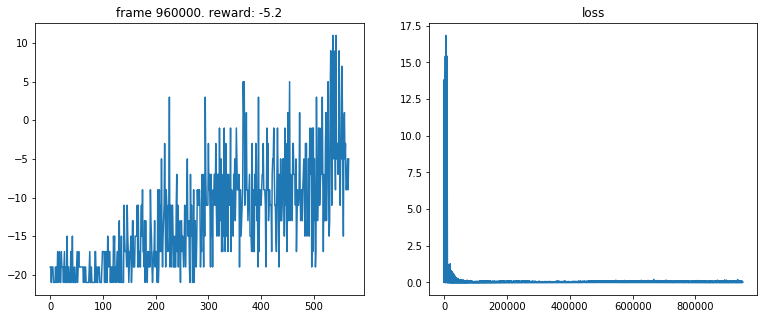

Frame:  960000


In [ ]:
Training(risk="Low",sample_ratio="Low",epsilon="Low",buffer_size="Low")

In [ ]:
# save all rewards
np.save("all_rewards.npy",all_rewards)